In [ ]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import common
import plotting

In [3]:
analytical_retardation_type = "langmuir"

In [4]:
base_dir = Path(f"../data_out/{analytical_retardation_type}/finn_c_plus_better_noise")

In [5]:
import re


def extract_values(folder_name):
    """
    Extracts test number, index, and s from a folder name.

    Args:
      folder_name: The name of the folder.

    Returns:
      A tuple containing the test number, index, and s.
    """
    match = re.search(r"test(\d+)_?(?:(\d+)_)?.*_s=([\d.]+)", folder_name)
    if match:
        test_number = int(match.group(1))
        index = int(match.group(2)) if match.group(2) else None
        s = float(match.group(3))
        return test_number, index, s
    else:
        return None, None, None

In [6]:
records = []
for finn_dir, ret_file_path in common.iter_final_retardation_files(
    base_dir, min_epoch=10, verbose=False
):
    test_number, index, s = extract_values(finn_dir.name)
    epochs = len(list((finn_dir / "predicted_concentrations").iterdir()))
    if epochs < 100:
        print(finn_dir.name, "did not converge")
        continue

    records.append(
        {
            "finn_dir": finn_dir,
            "ret_file_path": ret_file_path,
            "test_nr": test_number,
            "t_max_idx": 2001 if index is None else index,
            "fac": s,
        }
    )

df = pd.DataFrame.from_records(records)
print(len(df))
df.head()

154821933_cFullNoise_test1_None_sigma=0.08939152956008911_s=2.0_finn_c_plus_better_noise did not converge
399622636_cFullNoise_test2_None_sigma1=0.011585406959056854_sigma2=0.033110353350639346_s=0.5_finn_c_plus_better_noise did not converge
114604960_cFullNoise_test1_None_sigma=0.022347882390022278_s=0.5_finn_c_plus_better_noise did not converge
972747347_cFullNoise_test3_sigma1=0.02501155436038971_sigma2=0.07108771800994873_s=1.0_finn_c_plus_better_noise did not converge
109261043_cFullNoise_test2_None_sigma1=0.04634162783622742_sigma2=0.13244141340255738_s=2.0_finn_c_plus_better_noise did not converge
777123724_cFullNoise_test1_51_sigma=0.011088886857032777_s=1.0_finn_c_plus_better_noise did not converge
14


,finn_dir,ret_file_path,test_nr,t_max_idx,fac
0,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,3,2001,2.0
1,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,3,2001,0.5
2,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,2,51,1.0
3,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,1,2001,1.0
4,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,2,51,2.0


In [7]:
t_train_idx = np.load(df.iloc[0]["finn_dir"] / "c_train.npy").shape[0]
c_full_original = np.load(
    f"../data/FINN_forward_solver/retardation_{analytical_retardation_type}/c_train.npy"
)[..., None]
c_train_original = c_full_original[:t_train_idx]
display(c_full_original.shape)
display(c_train_original.shape)

(2001, 2, 26, 1)

(51, 2, 26, 1)

In [8]:
def mse(a, b):
    return np.square(a - b).mean()


df["MSE_c(train, original)"] = df.apply(
    lambda x: mse(np.load(x["finn_dir"] / "c_train.npy"), c_train_original), axis=1
)
df["MSE_c(pred_full, full)"] = df.apply(
    lambda x: mse(np.load(x["finn_dir"] / "c_full_predictions.npy"), np.load(x["finn_dir"] / "c_full.npy")), axis=1
)
df["MSE_c(pred_full, original)"] = df.apply(
    lambda x: mse(np.load(x["finn_dir"] / "c_full_predictions.npy"), c_full_original), axis=1
)
df["MSE_c(pred_train, original)"] = df.apply(
    lambda x: mse(np.load(x["finn_dir"] / "c_train_predictions.npy"), c_train_original),
    axis=1,
)
df["MSE_c(pred_train, train)"] = df.apply(
    lambda x: mse(
        np.load(x["finn_dir"] / "c_train.npy"),
        np.load(x["finn_dir"] / "c_train_predictions.npy"),
    ),
    axis=1,
)
df.head()

,finn_dir,ret_file_path,test_nr,t_max_idx,fac,"MSE_c(train, original)","MSE_c(pred_full, full)","MSE_c(pred_full, original)","MSE_c(pred_train, original)","MSE_c(pred_train, train)"
0,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,3,2001,2.0,0.000680,0.010137,0.000077,1.003590e-05,0.000684
1,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,3,2001,0.5,0.000048,0.000643,0.000003,6.511727e-07,0.000048
2,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,2,51,1.0,0.000159,0.000728,0.000570,2.756061e-04,0.000418
3,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,1,2001,1.0,0.002002,0.014609,0.012603,3.971358e-03,0.005946
4,../data_out/langmuir/finn_c_plus_better_noise/...,../data_out/langmuir/finn_c_plus_better_noise/...,2,51,2.0,0.000572,0.001814,0.001202,8.061535e-04,0.001382


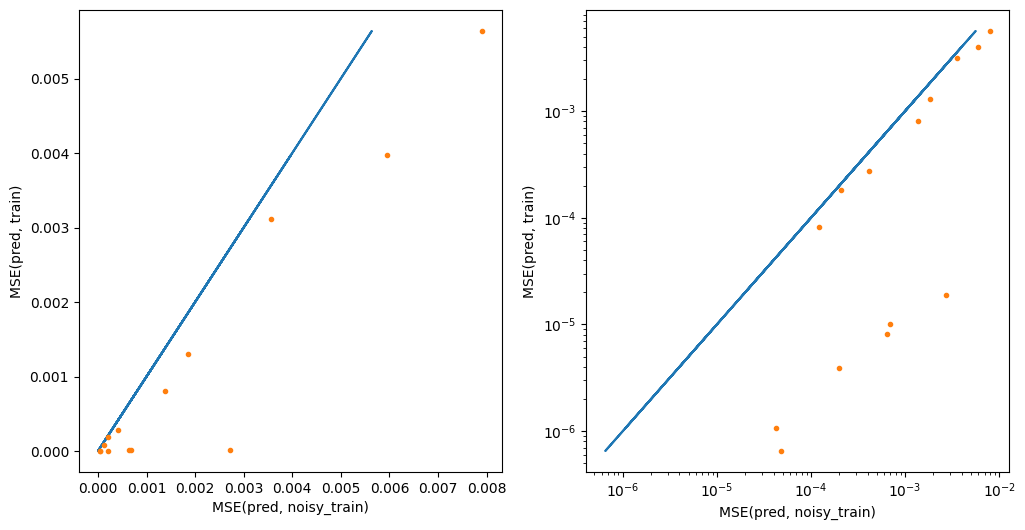

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.plot(df["MSE_c(pred_train, original)"], df["MSE_c(pred_train, original)"], "-")
ax1.plot(df["MSE_c(pred_train, train)"], df["MSE_c(pred_train, original)"], ".")
ax1.set_xlabel("MSE(pred, noisy_train)")
ax1.set_ylabel("MSE(pred, train)")

ax2.loglog(df["MSE_c(pred_train, original)"], df["MSE_c(pred_train, original)"], "-")
ax2.loglog(df["MSE_c(pred_train, train)"], df["MSE_c(pred_train, original)"], ".")
ax2.set_xlabel("MSE(pred, noisy_train)")
ax2.set_ylabel("MSE(pred, train)")

plt.show()

MSE with noisy training data is higher than error on clean data => No overfitting

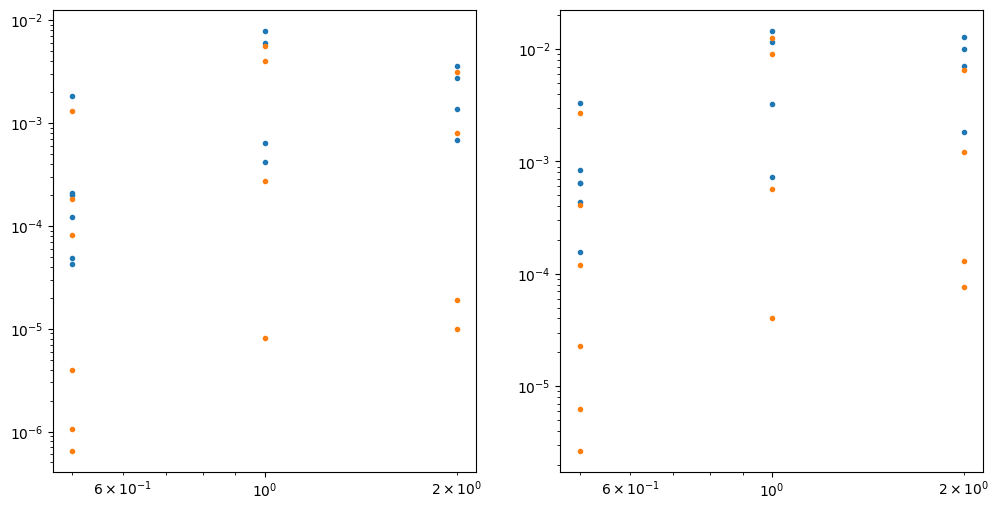

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.loglog(df["fac"], df["MSE_c(pred_train, train)"], ".")
ax1.loglog(df["fac"], df["MSE_c(pred_train, original)"], ".")

ax2.loglog(df["fac"], df["MSE_c(pred_full, full)"], ".")
ax2.loglog(df["fac"], df["MSE_c(pred_full, original)"], ".")

plt.show()

C-Error increases with increasing noise, but not too strongly.

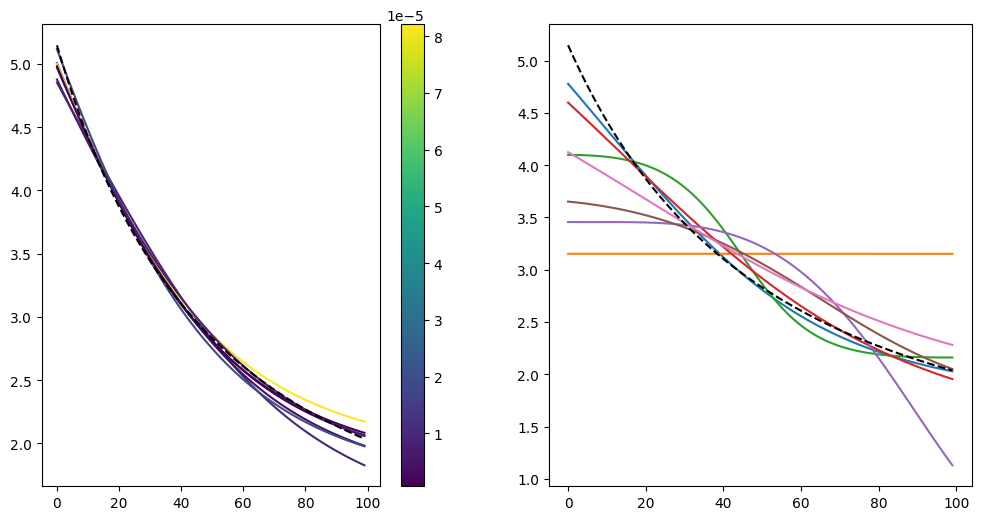

In [11]:
MSE_threshold_type = "MSE_c(pred_train, original)"
threshold = 1e-4

values = df[df[MSE_threshold_type] < threshold][MSE_threshold_type].values

colormap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=values.min(), vmax=values.max())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

for i, ret_file_path in enumerate(df["ret_file_path"]):
    ret = np.load(ret_file_path)
    color = colormap(norm(df[MSE_threshold_type].iloc[i]))
    if df[MSE_threshold_type].iloc[i] < threshold:  # c_pred, c_train, c_train + noise
        ax1.plot(ret, color=color)
    else:
        ax2.plot(ret)  # , color=color)

analytical_retardation = np.load(
    f"../data_out/{analytical_retardation_type}/default_finn/retardation_{analytical_retardation_type}.npy"
)

ax1.plot(analytical_retardation, "k--")
ax2.plot(analytical_retardation, "k--")

# Create ScalarMappable
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Add colorbar to ax1
plt.colorbar(sm, ax=ax1)

if analytical_retardation_type == "freundlich":
    ax1.set_ylim(3, 5)
    ax2.set_ylim(3, 5)

plt.show()

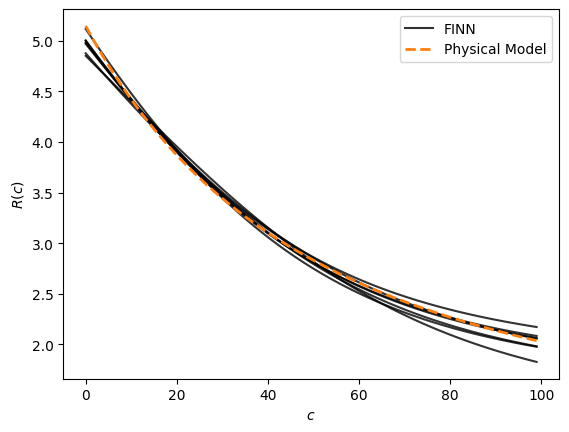

In [ ]:
for i, ret_file_path in enumerate(df["ret_file_path"]):
    ret = np.load(ret_file_path)
    if df[MSE_threshold_type].iloc[i] < threshold:  # c_pred, c_train, c_train + noise
        plt.plot(ret, "k-", alpha=0.8, label="FINN" if i == 0 else "")

plt.plot(analytical_retardation, "--", color="C1", lw=2, label="Physical Model")
plt.legend()
if analytical_retardation_type == "freundlich":
    plt.ylim(3, 5)
    plt.ylim(3, 5)

plt.xlabel("$c$")
plt.ylabel("$R(c)$")
plt.show()

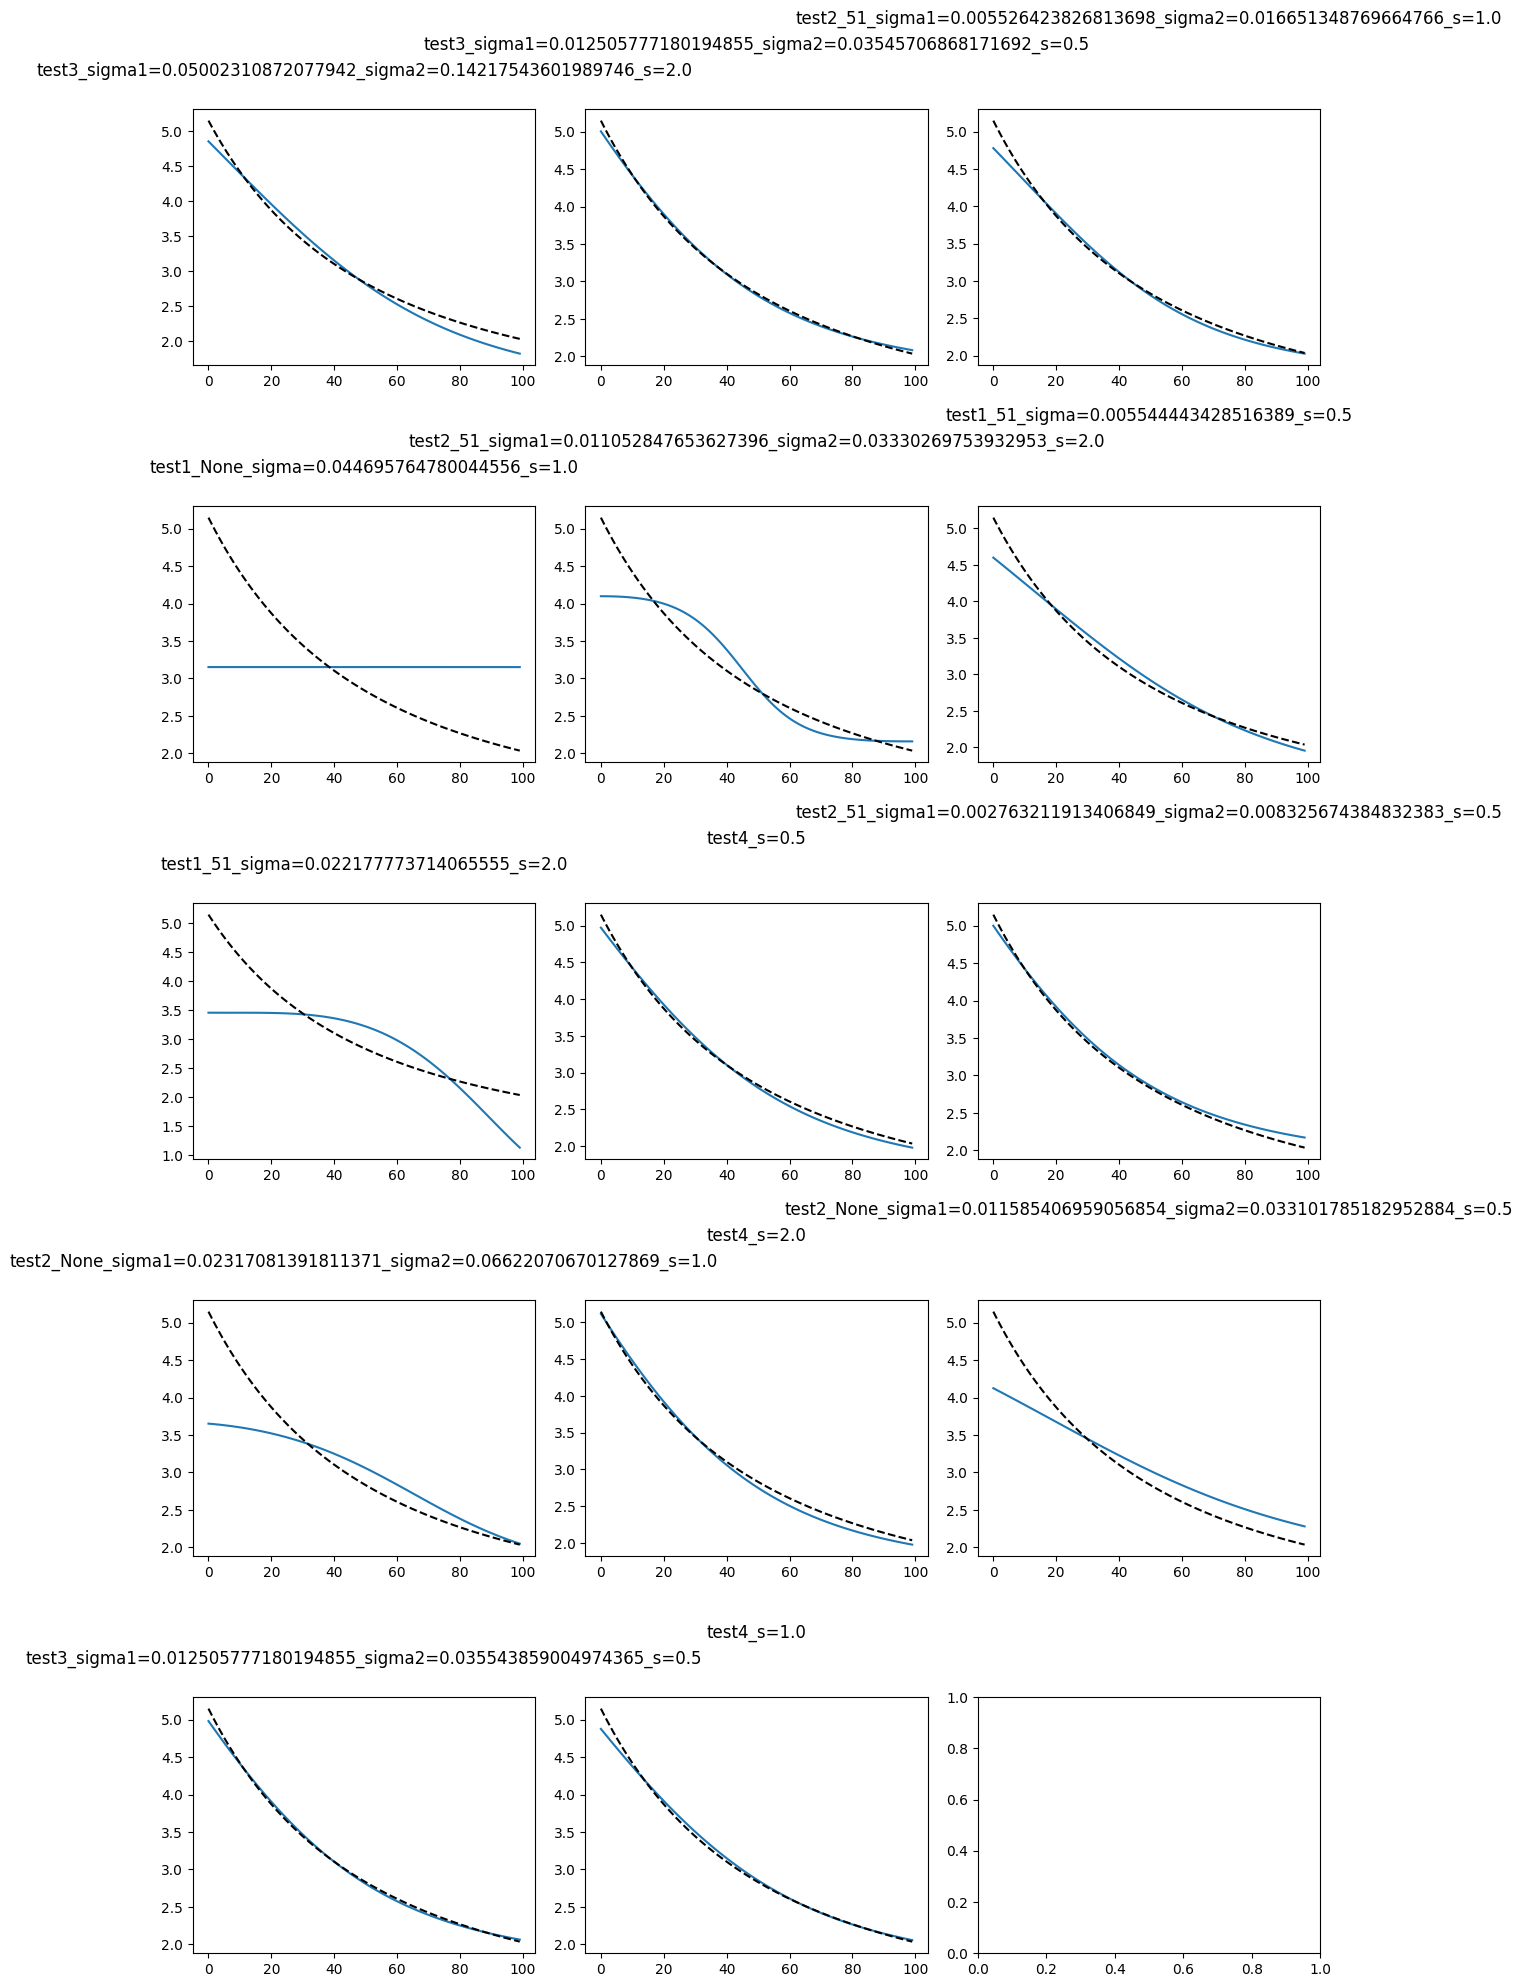

In [13]:
ncols=3
nrows = int(np.ceil(len(df) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols,4*nrows))
axs=axs.flat

for i, ax in zip(range(len(df)), axs):
    col = i % ncols
    ret = np.load(df.iloc[i]["ret_file_path"])
    ax.plot(ret)
    ax.plot(analytical_retardation, "k--")
    title = "_".join(df.iloc[i]["finn_dir"].name.split("_")[2:-5])
    ax.set_title(title, y=1.0 + (col+1)*0.1)
plt.tight_layout()